In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numbers import Number
from typing import Optional, Any
from numpy.typing import ArrayLike

from functools import reduce

In [37]:
sns.set_theme("paper")

In [38]:
def _df_colors(val: Any):
    '''Функция для более выделяющихся цветов в датафреймах'''
    
    if isinstance(val, bool) and val is False:
        color = "red"
    elif isinstance(val, bool) and val is True:
        color = "limegreen"
    elif isinstance(val, Number):
        # color = "gold"
        color = "mediumspringgreen"
    else:
        color = "cornflowerblue"
    return "color: %s" % color

In [39]:
def cols2drop(corr_df, threshold=0.9) -> list[str]:
    '''Функия для определения слишком коррелирующих признаков'''
    corr_df = corr_df.abs()
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    tri_corr = corr_df.mask(mask)
    to_drop = [c for c in tri_corr.columns if any(tri_corr[c] > threshold)]
    return to_drop, mask

In [40]:
emo2num = {'С': 1,
           'О': 2,
           'Н': 3,
           'Ж': 4,
           'У': 5,
           'Р': 6,
           'Г': 7,
           'Б': 8,
           'З': 9,
           'В': 10}

num2emo = {val: key for key, val in emo2num.items()}

letter2emo = {
"Г": "грусть",
"З": "злость",
"Р": "радость",
"У": "удивление",
"В": "волнение",
"Ж": "раздражение",
"Н": "недовольство",
"О": "обида",
"Б": "обречённость",
"С": "страх"
}

In [41]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#, multilabel_confusion_matrix
from sklearn.inspection import permutation_importance

In [43]:
std_scaler = StandardScaler()

In [44]:
def print_metrics(y_preds: ArrayLike, 
                  y: ArrayLike, 
                  y_probs: Optional[ArrayLike] = None
) -> None:
    print(f'MSE: {mean_squared_error(y_preds, y)}')
    print(f"Accuracy: {accuracy_score(y_preds, y)}")
    print(f"F-score: {f1_score(y, y_preds, average='weighted')}")
    if y_probs is not None: 
        print(f"ROC-AUC: {roc_auc_score(y, y_probs, multi_class='ovr')}")

In [45]:
def show_conf_matrx(y_real: ArrayLike, y_preds: ArrayLike, classes: ArrayLike, title: str="") -> None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title(title)
    cm_rfc = confusion_matrix(y_real, y_preds)
    disp_rfc = ConfusionMatrixDisplay(cm_rfc, 
                                      display_labels=[letter2emo[num2emo[klas]] for klas in classes])
    disp_rfc.plot(include_values=True, cmap="viridis", ax=ax, colorbar=True)

In [46]:
def show_roc_curves(y_train: ArrayLike, y_test: ArrayLike, y_score: ArrayLike, classes: ArrayLike) -> None:
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fig, axs = plt.subplots(ncols=2,
                            nrows=2, 
                            figsize=(15, 10))
    for class_of_interest, axis in zip(classes, axs.flatten()):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{letter2emo[num2emo[class_of_interest]]} vs the rest",
            color="darkorange",
            plot_chance_level=True,
            ax=axis
        )
        _ = display.ax_.set(
            xlabel="",
            ylabel="",
            # title="One-vs-Rest ROC curves",
        )

In [47]:
def show_feature_importances(importances: ArrayLike, feature_names: ArrayLike, title: str, size=(6,6)) -> None:
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    sorted_importance = importances_df.sort_values(by='Importance', ascending=False)
    sorted_importance = sorted_importance[sorted_importance != 0]
    # fig, ax = plt.subplots(figsize=(10,6))
    plt.figure(figsize=size)
    plt.barh(sorted_importance['Feature'], sorted_importance['Importance'])
    plt.title(title)

# Reading text data

In [48]:
# собираем признаки, полученные в другом ноутбуке в большую признаковую матрицу
basic_metrics_DF = pd.read_csv("basic_metrics_DF.csv", index_col=0)
pos_DF = pd.read_csv("pos_DF.csv", index_col=0)
Ngrams_DF = pd.read_csv("Ngrams_DF.csv", index_col=0)
gramm_DF = pd.read_csv("gramm_DF.csv", index_col=0)
emotion_DF = pd.read_csv("emotion_DF.csv", index_col=0)
syntax_DF = pd.read_csv("syntax_DF.csv", index_col=0)
zipf_DF = pd.read_csv("zipf_DF.csv", index_col=0)

In [49]:
data_frames = [basic_metrics_DF, pos_DF, Ngrams_DF, gramm_DF, emotion_DF, syntax_DF, zipf_DF]

In [50]:
wholeDF = reduce(lambda left,right: pd.merge(left, right, how='outer'), data_frames)
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
1,0107635181_00__00-channel-0-number-005_22100,С,1,10,22,2,0.200000,2.200000,4.900000,1,0.100000,0.909091,0.000000,0.000000,0.000000,0.090909,0.272727,0.090909,0.000000,0.363636,0.454545,0.090909,0.333333,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.090909,0.000000,0.090909,0.090909,0.181818,0.181818,0.090909,0.000000,0.181818,0.090909,0.000000,0.000000,1,1,0,1,0,1,1,0,0,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,0,0,2,3,3,1
2,0107635181_00__00-channel-0-number-006_26690,С,1,11,17,0,0.000000,1.416667,3.583333,0,0.000000,0.916667,40.333333,247.933884,40.333333,0.416667,0.083333,0.166667,0.166667,0.083333,0.500000,0.333333,2.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.250000,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0,0,1,1,0,2,0,0,0,0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,0,0,0,0,0,4,3,2,3
3,0107636961_00__00-channel-0-number-009_34800,С,1,7,15,1,0.125000,1.875000,4.125000,0,0.000000,0.875000,16.333333,612.244898,16.333333,0.000000,0.375000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,1,1,1,2,2,0
4,0107638181_00__00-channel-0-number-018_59400,С,1,5,11,1,0.200000,2.200000,4.800000,1,0.200000,0.833333,0.000000,0.000000,0.000000,0.166667

# MFCC

In [51]:
import librosa

In [52]:
y, sr = librosa.load(r"C:\Users\Ivan\Desktop\AI\0_Dissertation\emo_audio\0107578611_00__00-channel-0-number-001_3070.wav")

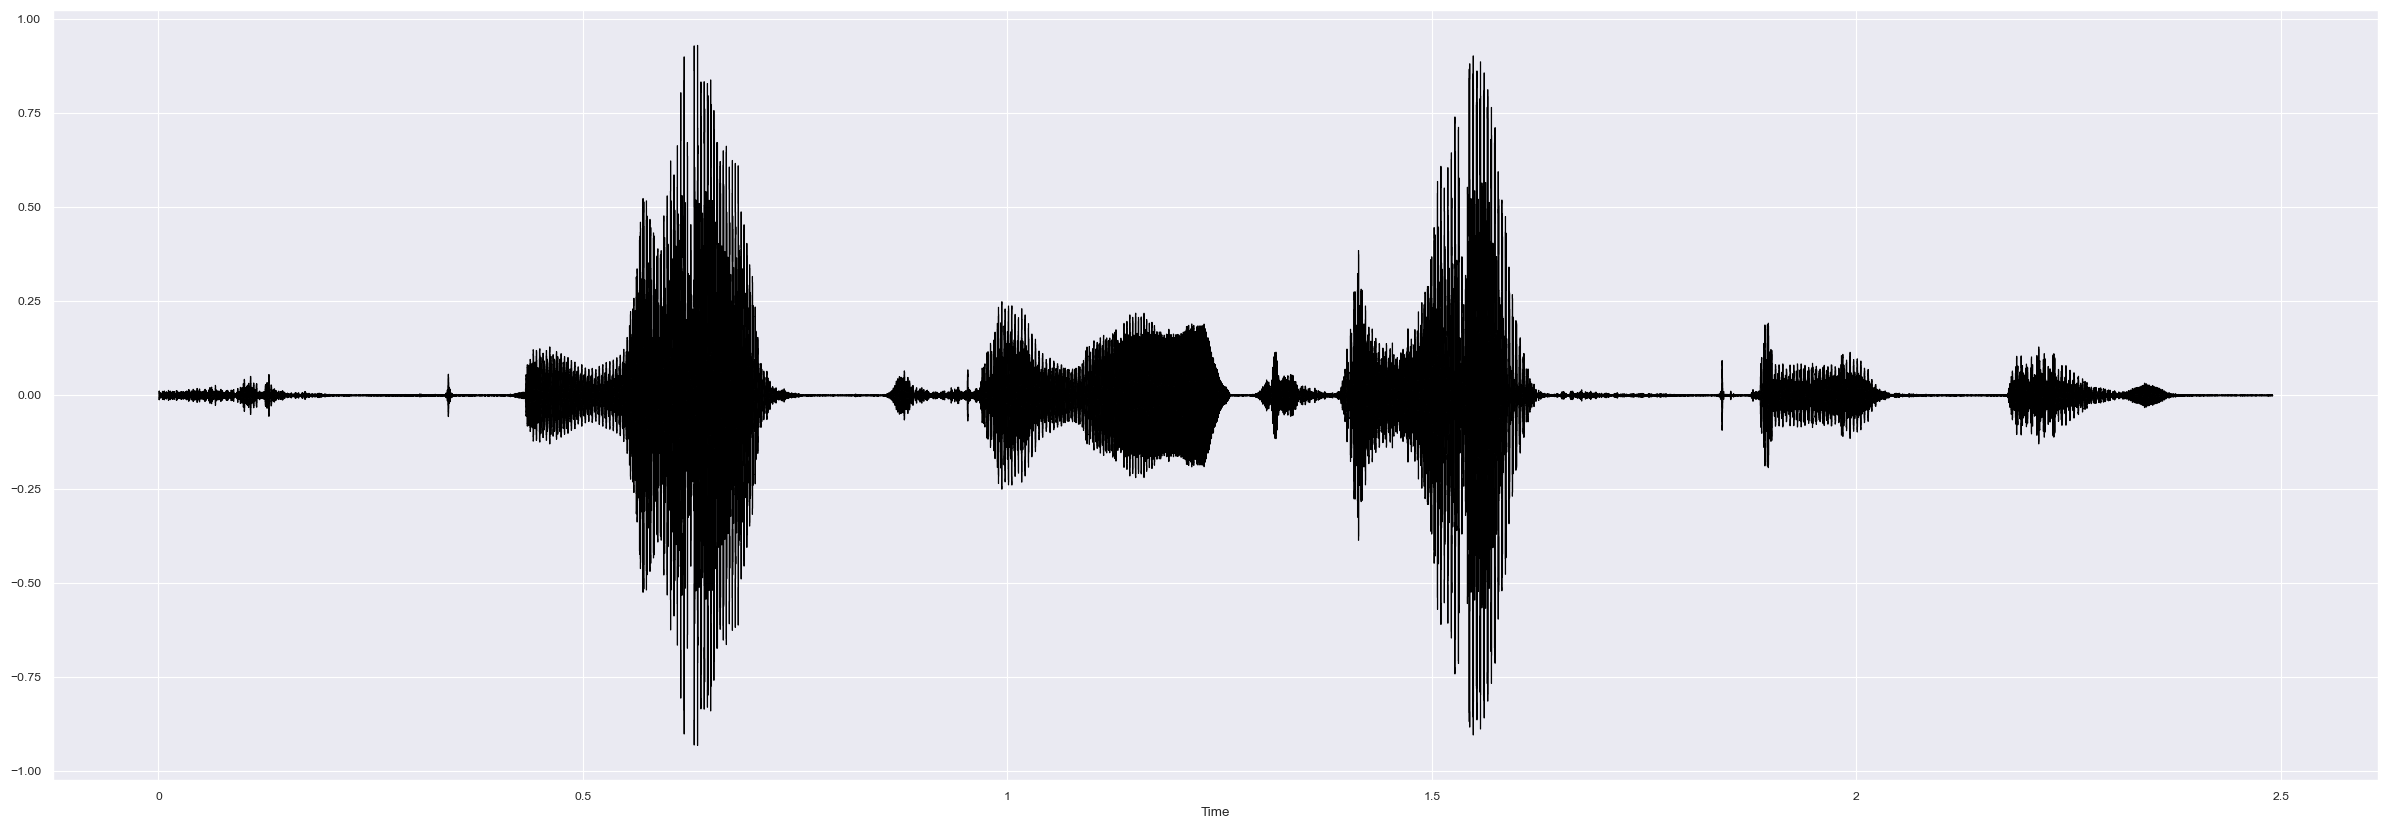

In [53]:
plt.figure(figsize=(30,10))
librosa.display.waveshow(y, sr=sr, color="black");

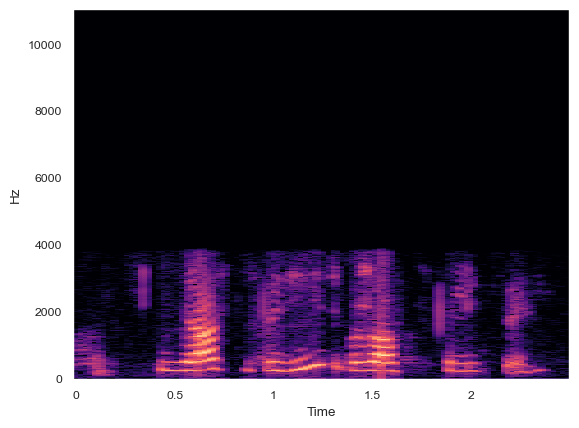

In [54]:
# plt.figure(figsize=(30,10))
D = np.abs(librosa.stft(y))
db = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(db, sr=sr, y_axis='hz', x_axis='time');

In [55]:
frame_width = 20 # ms
frame_step = 10 # ms

print(frame_width := round(frame_width * 0.001 * sr)) # ms to the number of samples
print(frame_step := round(frame_step * 0.001 * sr)) # ms to the number of samples

print(nfft := int(2**np.ceil(np.log2(frame_width)))) # closest upper power of 2 for frame width

441
220
512


In [56]:
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=nfft, hop_length=frame_step, win_length=frame_width)

In [57]:
MFCCs = {"IDs": list(wholeDF["IDs"])}
for i in range(13):
    MFCCs[f"MFCC{i+1}"] = []

In [58]:
for i, filename in enumerate(wholeDF["IDs"]):
# get the time series
    y, sr = librosa.load(rf"C:\Users\Ivan\Desktop\AI\0_Dissertation\emo_audio2\{filename}.wav")
# get the coefficients
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=nfft, hop_length=frame_step, win_length=frame_width)
# scale the coefficients
    mfccScaled = np.mean(mfcc.T, axis=0)

    for j in range(len(mfccScaled)):
        MFCCs[f"MFCC{j+1}"].append(mfccScaled[j])

In [59]:
mfccDF = pd.DataFrame(MFCCs)
mfccDF.head().style.map(_df_colors)

,IDs,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13
0,0107635181_00__00-channel-0-number-004_18310,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556
1,0107635181_00__00-channel-0-number-005_22100,-408.129059,156.219803,-50.914352,7.203946,17.909063,-39.309731,-9.709213,-2.864349,-24.096661,-5.696147,-9.311288,-14.882713,2.547493
2,0107635181_00__00-channel-0-number-006_26690,-420.051056,156.462692,-51.804707,14.146825,21.260660,-43.143650,-10.840601,-2.410405,-26.338383,-8.020977,-9.845235,-13.113922,4.449926
3,0107636961_00__00-channel-0-number-009_34800,-426.520721,146.728928,-62.518063,27.929390,32.911354,-50.893284,-17.124662,-3.472899,-27.367807,-4.063274,-8.074554,-16.785032,3.742684
4,0107638181_00__00-channel-0-number-018_59400,-411.087433,154.948792,-80.103027,19.974255,32.999275,-49.204975,-8.682093,-2.568156,-37.145340,-3.738223,0.261289,-17.637541,0.900998


# Merging

In [60]:
merged = pd.merge(mfccDF, wholeDF)
merged.head().style.map(_df_colors)

,IDs,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556,С,1,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
1,0107635181_00__00-channel-0-number-004_18310,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556,В,10,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
2,0107635181_00__00-channel-0-number-004_18310,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556,С,1,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
3,0107635181_00__00-channel-0-number-004_18310,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556,В,10,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0

In [61]:
merged.insert(1, "Primary Emotion", merged.pop("Primary Emotion"))
merged.insert(2, "Emotion Class", merged.pop("Emotion Class"))
merged.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
1,0107635181_00__00-channel-0-number-004_18310,В,10,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
2,0107635181_00__00-channel-0-number-004_18310,С,1,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
3,0107635181_00__00-channel-0-number-004_18310,В,10,-430.050812,151.687164,-45.405285,6.089986,16.060833,-35.592243,-7.429289,-2.388579,-23.355518,-7.821520,-13.513171,-17.238529,2.689556,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0

In [62]:
classes_merge_table = {1: 10,
                       2: 7,
                       3: 3,
                       4: 3,
                       5: 5,
                       6: 5,
                       7: 7,
                       8: 7,
                       9: 3,
                       10: 10}

In [63]:
merged = merged.replace({"Emotion Class": classes_merge_table})
set(merged["Emotion Class"])

{3, 5, 7, 10}

In [64]:
X_train, X_test, y_train, y_test = train_test_split(merged[merged.columns[3:]], 
                                                    merged["Emotion Class"], 
                                                    test_size=0.1, # данных не так много, берём максимум на обучение 
                                                    shuffle=True, 
                                                    random_state=42)

In [65]:
cbc = CatBoostClassifier()

cbc.fit(X_train, y_train)
preds_class = cbc.predict(X_test)
print_metrics(preds_class, y_test, cbc.predict_proba(X_test))

Learning rate set to 0.084149
0:	learn: 1.3403422	total: 72.7ms	remaining: 1m 12s
1:	learn: 1.3031198	total: 111ms	remaining: 55.5s
2:	learn: 1.2706574	total: 147ms	remaining: 48.7s


3:	learn: 1.2422308	total: 194ms	remaining: 48.2s
4:	learn: 1.2167285	total: 272ms	remaining: 54.2s
5:	learn: 1.1931828	total: 446ms	remaining: 1m 13s
6:	learn: 1.1743682	total: 636ms	remaining: 1m 30s
7:	learn: 1.1563705	total: 712ms	remaining: 1m 28s
8:	learn: 1.1398837	total: 749ms	remaining: 1m 22s
9:	learn: 1.1262143	total: 819ms	remaining: 1m 21s
10:	learn: 1.1143561	total: 1.16s	remaining: 1m 44s
11:	learn: 1.1021397	total: 1.35s	remaining: 1m 51s
12:	learn: 1.0915200	total: 1.41s	remaining: 1m 46s
13:	learn: 1.0815277	total: 1.44s	remaining: 1m 41s
14:	learn: 1.0733935	total: 1.48s	remaining: 1m 37s
15:	learn: 1.0639267	total: 1.52s	remaining: 1m 33s
16:	learn: 1.0571323	total: 1.57s	remaining: 1m 30s
17:	learn: 1.0498533	total: 1.61s	remaining: 1m 28s
18:	learn: 1.0423134	total: 1.65s	remaining: 1m 25s
19:	learn: 1.0349820	total: 1.68s	remaining: 1m 22s
20:	learn: 1.0285213	total: 1.72s	remaining: 1m 20s
21:	learn: 1.0221730	total: 1.75s	remaining: 1m 17s
22:	learn: 1.0178536	

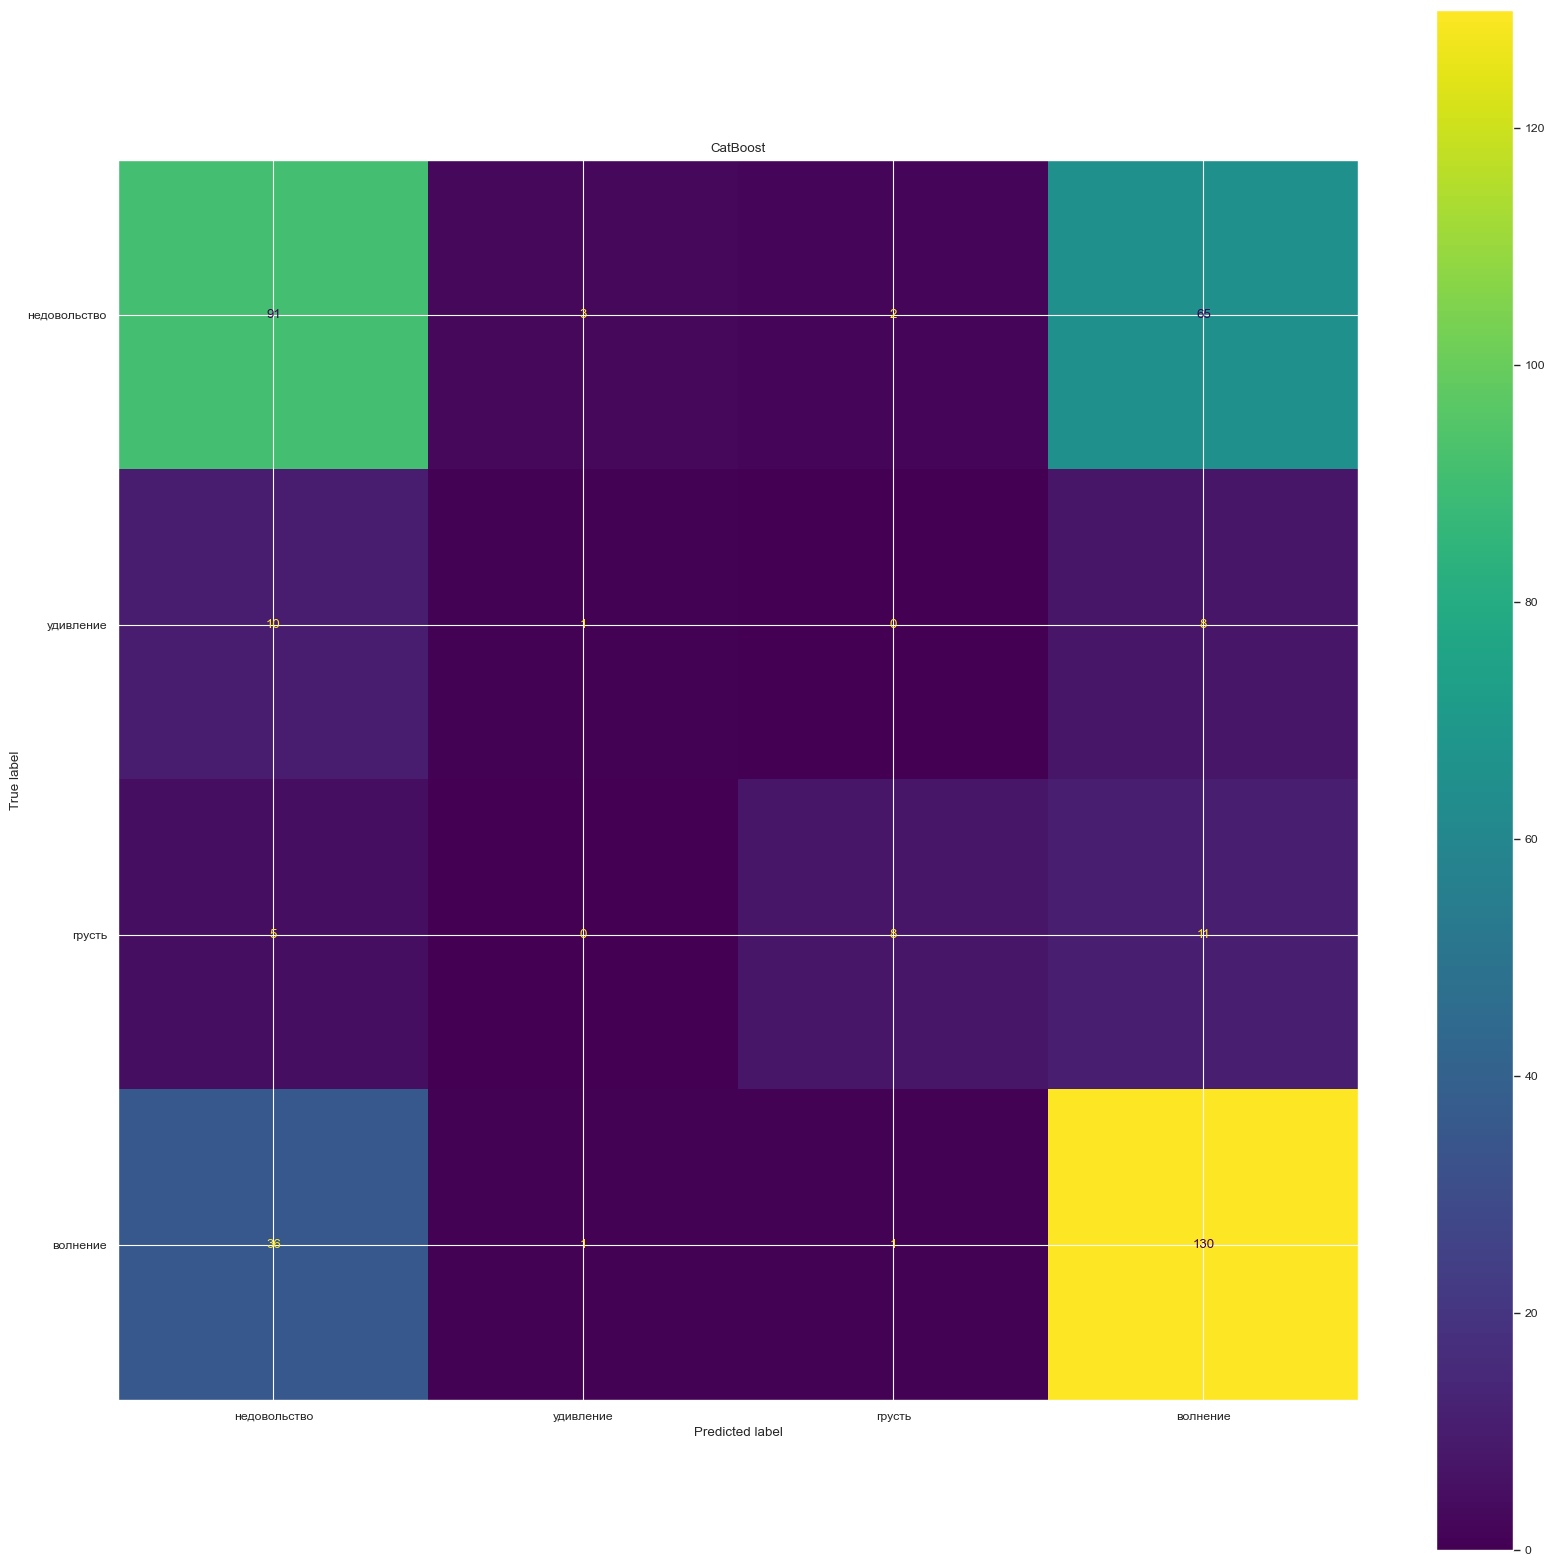

In [66]:
show_conf_matrx(y_test, cbc.predict(X_test), cbc.classes_, "CatBoost")

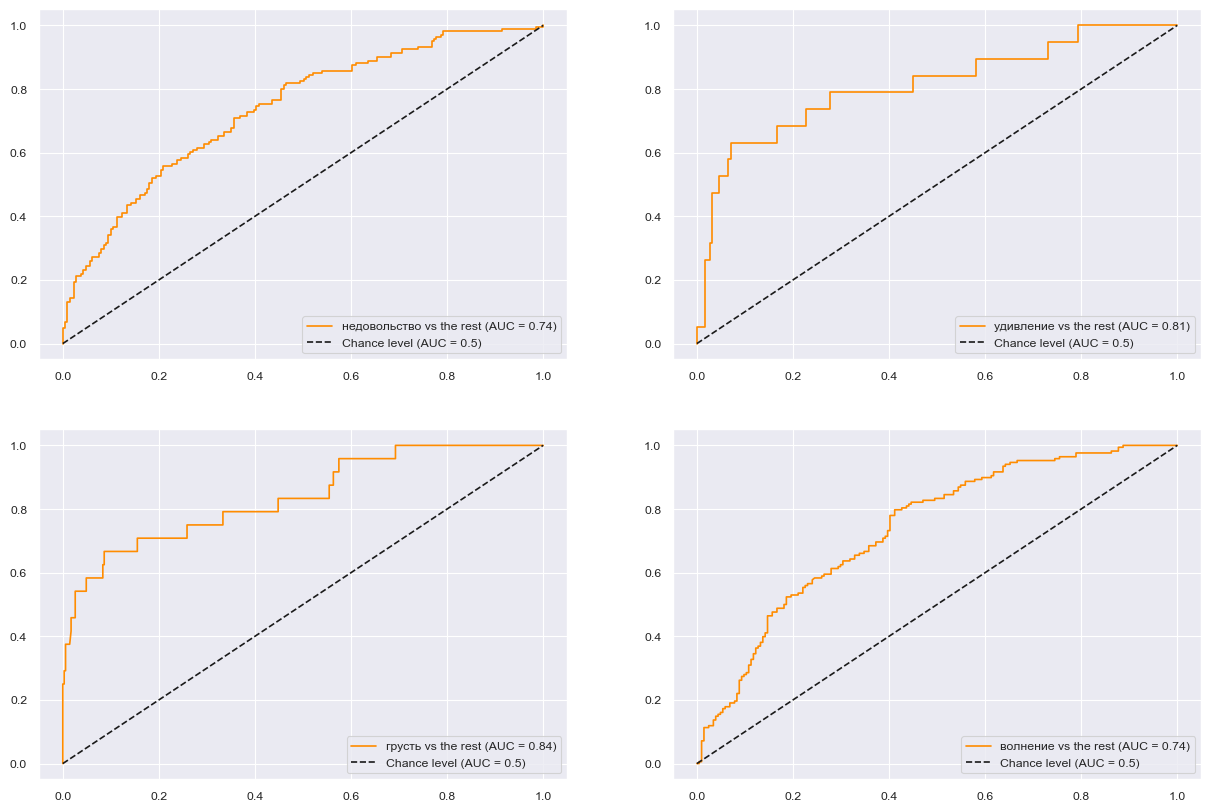

In [67]:
show_roc_curves(y_train, y_test, cbc.predict_proba(X_test), classes=cbc.classes_)

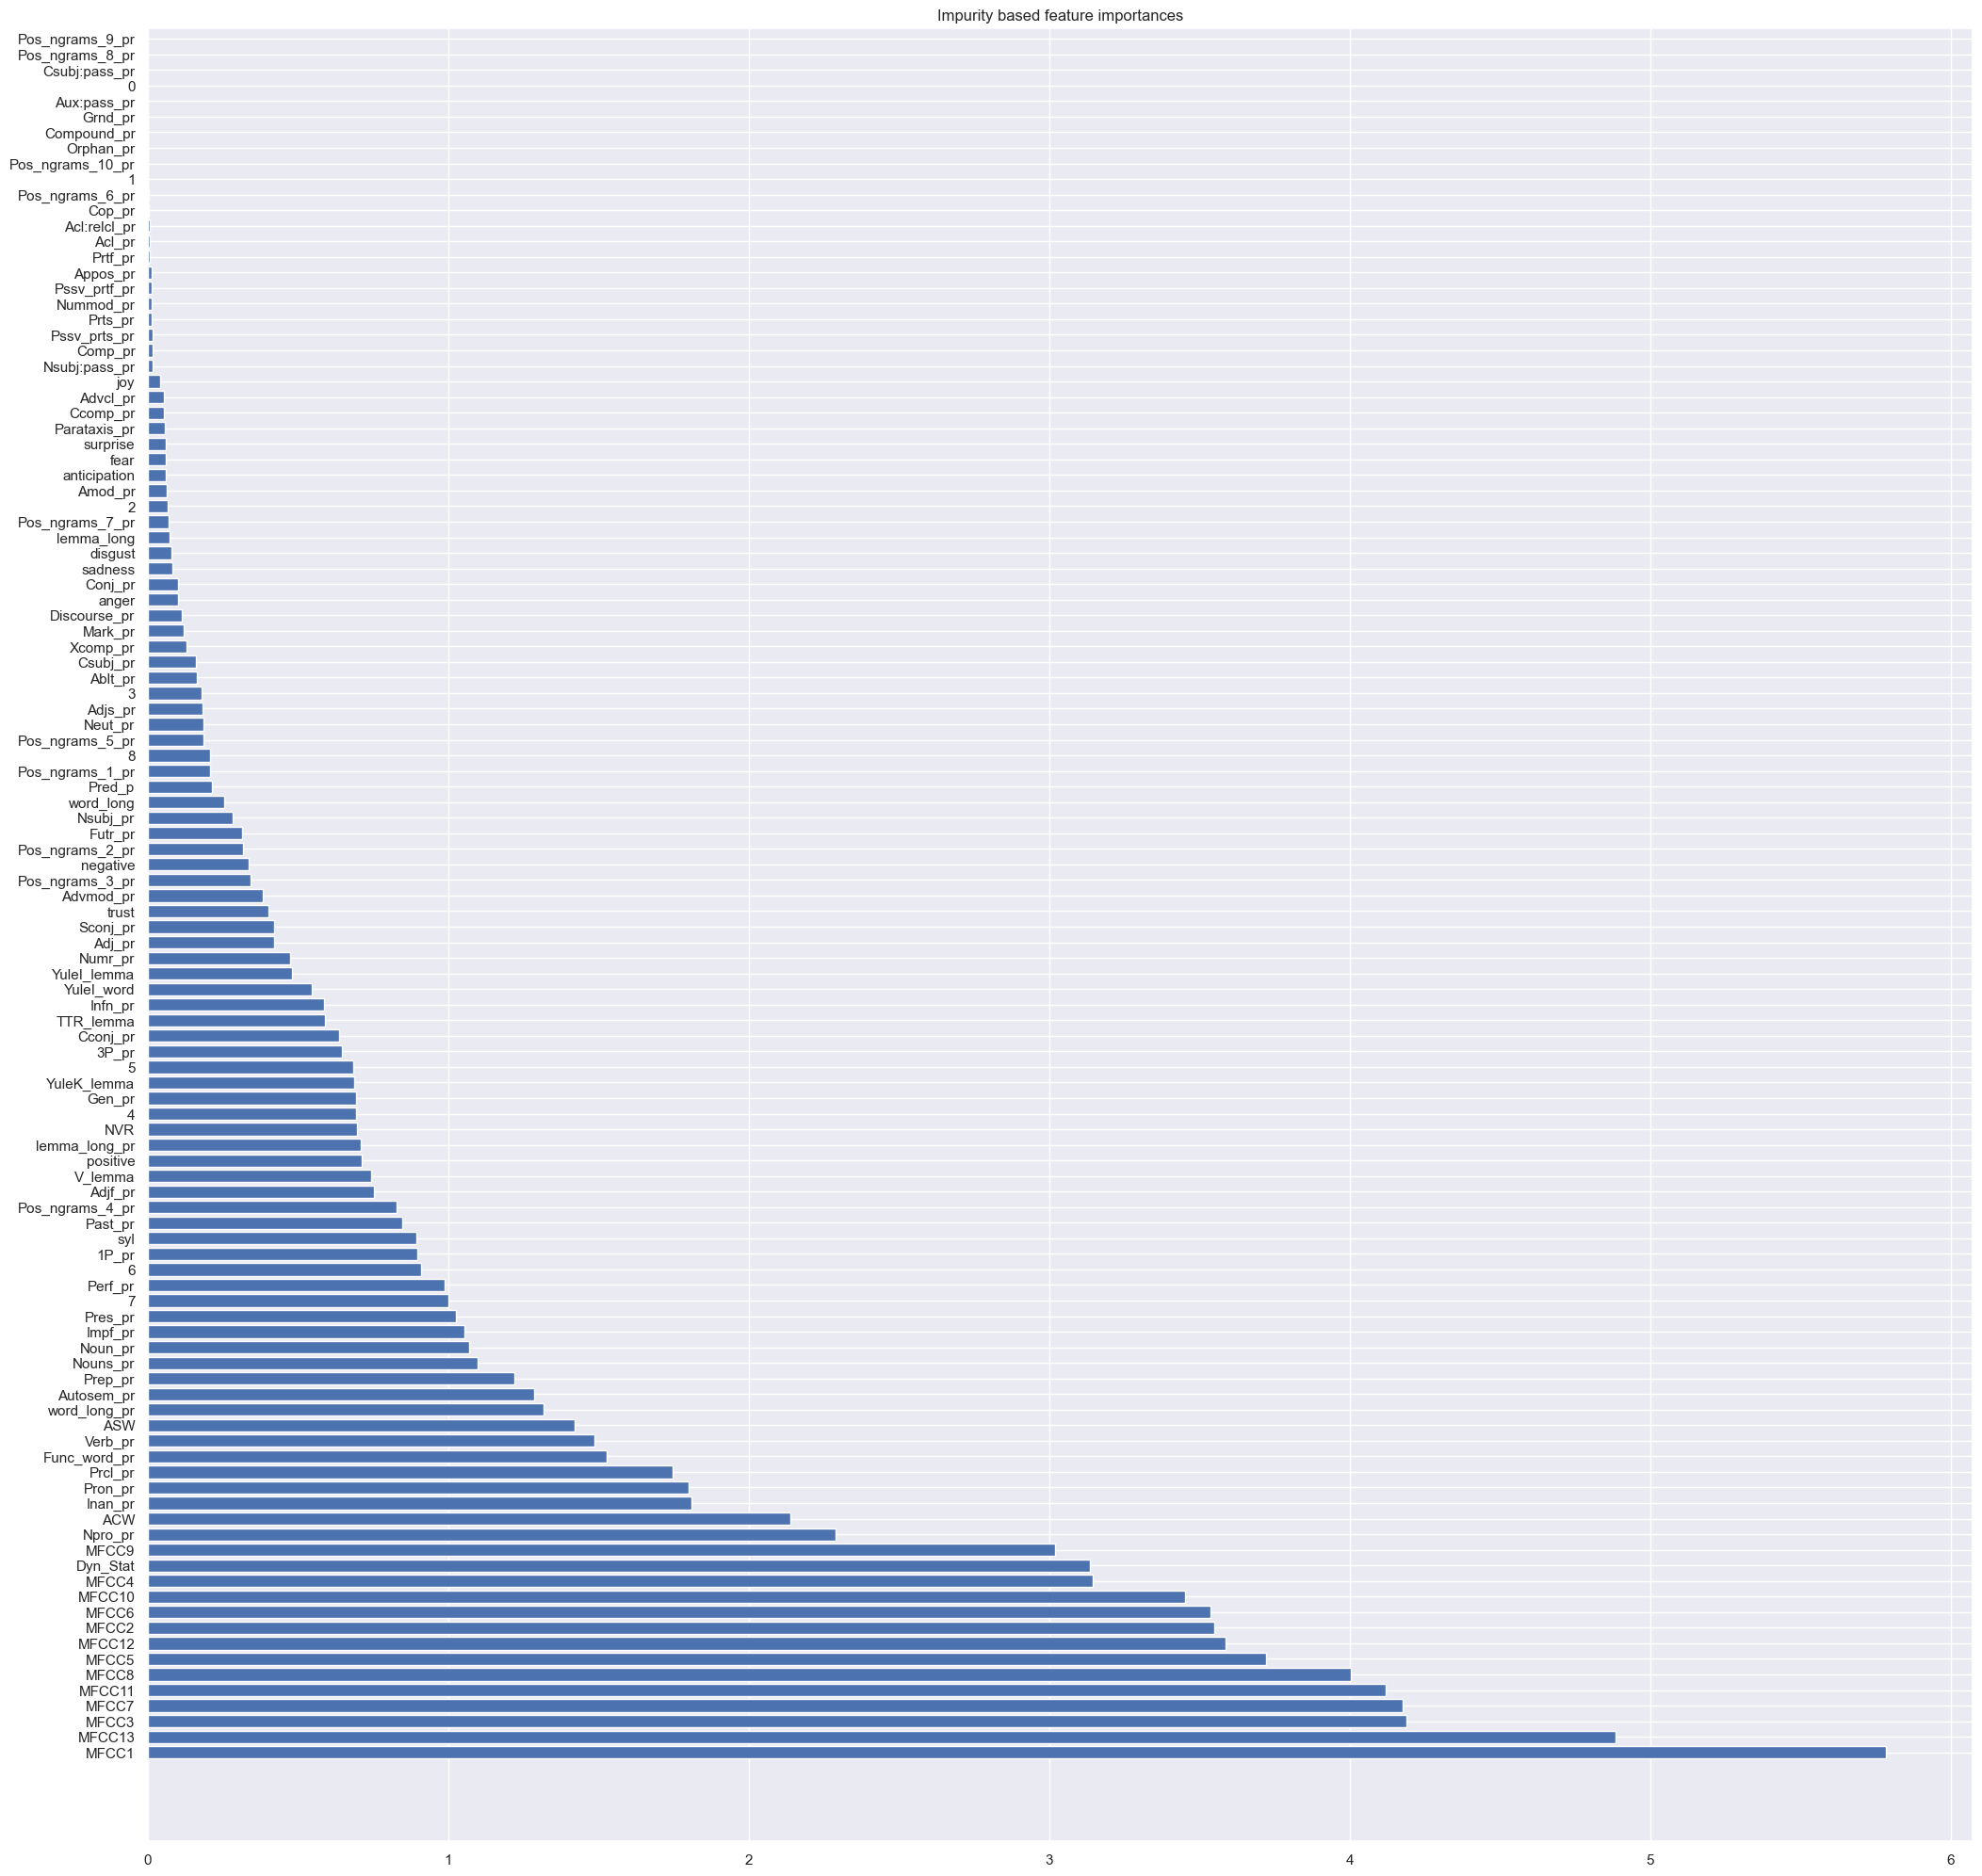

In [33]:
show_feature_importances(cbc.feature_importances_, X_test.columns, "Impurity based feature importances", size=(25,25))

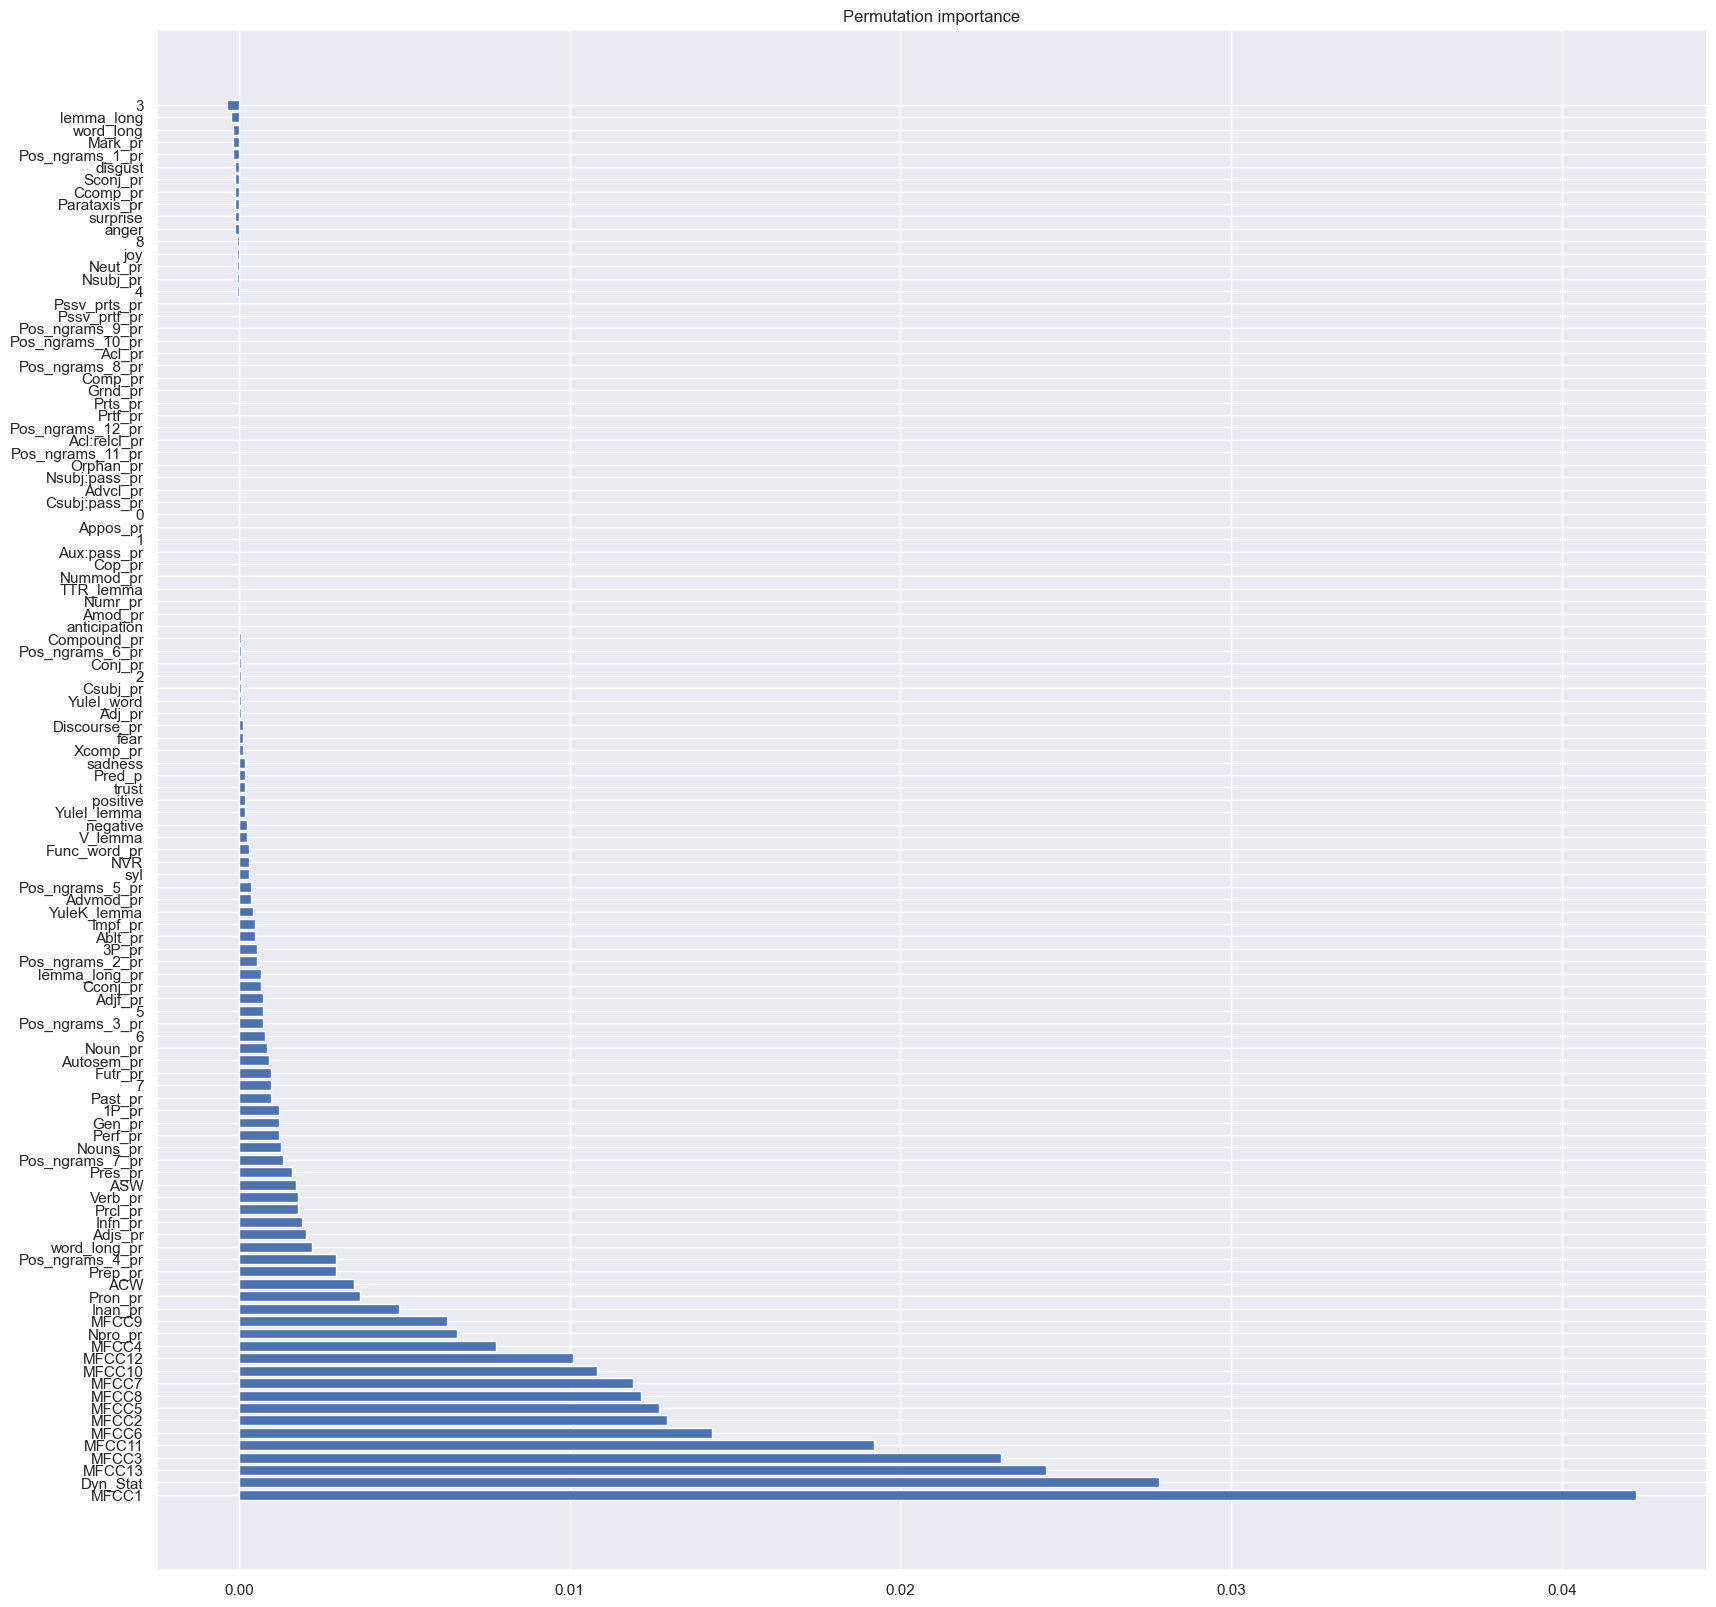

In [34]:
perm_imp_cbc = permutation_importance(cbc, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_cbc.importances_mean, X_test.columns, "Permutation importance", size=(20,20))